In [1]:
%pip install -qU "airavata-python-sdk[notebook]"
import airavata_jupyter_magic

%authenticate

# PLEASE NOTE: At a given time, ONLY run a single job in one of the available clusters: Anvil OR Jetstream. 
# Anvil is the default cluster and if you need to run on Jetstream; comment the Anvil and uncomment the Jetstream
# Anvil
%request_runtime test_cpu --file=cybershuttle.yml --group=Gkeyll --walltime=60 --use=AnvilCPU:shared
# Jetstream
# %request_runtime test_cpu --file=cybershuttle.yml --group=Gkeyll --walltime=60 --use=Gkeyll:cloud

%wait_for_runtime test_cpu --live
%switch_runtime test_cpu

  DEPRECATION: Building 'pysftp' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'pysftp'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  DEPRECATION: Building 'thrift' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'thrift'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  DEPRECATION: Building 'thrift_connector' using the legacy setup.py bdist_wheel mechani

Output()

Authenticated.

Requesting runtime=test_cpu...
[AnvilCPU:shared, 60 Minutes, 1 Node(s), 4 CPU(s), 1 GPU(s), 4096 MB RAM, 1024 MB VRAM]
* modules=[]
* libraries=['python=3.11', 'pip']
* pip=['numpy', 'matplotlib', 'postgkyl']
* mounts=[]
* links={}
Requested runtime=test_cpu
Request successful: runtime=test_cpu


Output()

local:/tmp/connection_a8azm6ef.json --> test_cpu:connection_a8azm6ef.json... [200]
started proc_name=test_cpu_kernel on rt=test_cpu. pid=3699763
forwarding ports=[20085, 20086, 20087, 20088, 20089]
test_cpu:20085 -> access via 18.118.140.230:10000
test_cpu:20086 -> access via 18.118.140.230:10001
test_cpu:20087 -> access via 18.118.140.230:10002
test_cpu:20088 -> access via 18.118.140.230:10003
test_cpu:20089 -> access via 18.118.140.230:10004
started ipykernel tunnels for test_cpu at 18.118.140.230
started ipykernel client for test_cpu
Remote Jupyter kernel launched and connected for runtime=test_cpu.
Switched to runtime=test_cpu.


In [3]:
!find ~/cybershuttle/dataset/Plasma-Vlab-amitava-class/ -mindepth 1 -maxdepth 1 -type d -exec ln -s {} . \;

executing cell on test_cpu...
waiting for cell to finish on test_cpu...
cell finished on test_cpu.


In [2]:
# Import python packages
import matplotlib
import matplotlib.pyplot as plt
import postgkyl as pg
import numpy as np

executing cell on test_cpu...
waiting for cell to finish on test_cpu...
cell finished on test_cpu.


In [4]:
# Helper function for computing vector potential
def calc_psi2d(fx, fy, dx=1, dy=1):#solenoidal flows
	'''
	Calcualte psi by integrating dpsi = -fy*dx + fx*dy, psi[0,0]=0.
	Notes: 
		1. (fx=dpsi/dy,fy=-dpsi/dx) is called Hamiltonian gradient of psi, and	contours of psi give vector field (fx, fy);
		2. div(f)=0
	'''
	ny,nx=fx.shape
	psi=np.zeros((ny,nx))
	for jx in range(1,nx):
		psi[0,jx]=psi[0,jx-1]-fy[0,jx]*dx
	for jy in range(1,ny):
		psi[jy,:]=psi[jy-1,:]+fx[jy,:]*dy
	# since f = rot(A) gives extra restraints on f (e.g., div(f)=0)
	# it makes sense that information provided by fy[1:nx,:] is useless here
	return psi

# Helper function for finding X-points
def find_saddles(mat : np.ndarray) -> list:                                                                                                                              
    (N, M) = mat.shape                                                                     
                                                                                           
    jMax = np.argmax(mat, axis = 1) # index of col for max in each row                     
    iMin = np.argmin(mat, axis = 0) # index of row for min in each col                     
                                                                                           
    IJMax = [(i,jMax[i]) for i in range(N)] # list of indexes of max of each row           
    IJMin = [(iMin[j],j) for j in range(M)] # list of indexes of min of each col           
                                                                                           
    maxRowMinCol = list(set(IJMax) & set(IJMin)) # max of row, min of col                         
                                                                                           
    iMax = np.argmax(mat, axis = 0) # index of row for max in each col                     
    jMin = np.argmin(mat, axis = 1) # index of col for min in each row                     
                                                                                           
    IJMax = [(iMax[j],j) for j in range(M)] # list of indexes of max of each col           
    IJMin = [(i,jMin[i]) for i in range(N)] # list of indexes of min of each row           
                                                                                           
    minRowMaxCol = list(set(IJMax) & set(IJMin)) # min of row, max of col                                                                                          
    
    return maxRowMinCol + minRowMaxCol  

executing cell on test_cpu...
waiting for cell to finish on test_cpu...
cell finished on test_cpu.


In [5]:
def get_Gdata(pre, frame):
    data_elc = pg.data.GData("%s-elc_%d.gkyl" % (pre, frame))
    data_ion = pg.data.GData("%s-ion_%d.gkyl" % (pre, frame))
    data_field = pg.data.GData("%s-field_%d.gkyl" % (pre, frame))

    return data_elc, data_ion, data_field

def read_data(data_elc, data_ion, data_field):
    fluid_elc = data_elc.get_values()
    fluid_ion = data_ion.get_values()  
    field = data_field.get_values()  

    # Same grid for all electrons, ions, and EM fields
    coords = data_elc.get_grid()
    # Center the grid values
    for d in range(len(coords)):
        coords[d] = 0.5*(coords[d][:-1] + coords[d][1:])

    return coords, fluid_elc, fluid_ion, field

executing cell on test_cpu...
waiting for cell to finish on test_cpu...
cell finished on test_cpu.


In [6]:
# Helper functions for simulated spacecraft measurement
import random
from scipy.optimize import minimize, curve_fit
from scipy.interpolate import griddata

def min_function(params, x, y, ymin, ymax):
    model = f_order3(x, *params)
    residual = ((y - model) ** 2).sum()
    
    if np.any(model > ymax):
        residual += 100  # Just some large value
    if np.any(model < ymin):
        residual += 100

    return residual

def f_order3(t,a,b,c,d,e,f):
	a*pow(t,3) + b*pow(t,2) + c*t + d
	return a*pow(t,5) + b*pow(t,4) + c*pow(t,3) + d*pow(t,2) + e*t + f

def find_saddles(mat : np.ndarray) -> list:                                                 
                                                                                           
    (N, M) = mat.shape                                                                     
                                                                                           
    jMax = np.argmax(mat, axis = 1) # index of col for max in each row                     
    iMin = np.argmin(mat, axis = 0) # index of row for min in each col                     
                                                                                           
    IJMax = [(i,jMax[i]) for i in range(N)] # list of indexes of max of each row           
    IJMin = [(iMin[j],j) for j in range(M)] # list of indexes of min of each col           
                                                                                           
    maxRowMinCol = list(set(IJMax) & set(IJMin)) # max of row, min of col                  
                                                                                           
                                                                                           
    iMax = np.argmax(mat, axis = 0) # index of row for max in each col                     
    jMin = np.argmin(mat, axis = 1) # index of col for min in each row                     
                                                                                           
    IJMax = [(iMax[j],j) for j in range(M)] # list of indexes of max of each col           
    IJMin = [(i,jMin[i]) for i in range(N)] # list of indexes of min of each row           
                                                                                           
    minRowMaxCol = list(set(IJMax) & set(IJMin)) # min of row, max of col                  
                                                                                           
                                                                                           
    return maxRowMinCol + minRowMaxCol

def lookupNearest(data, x, y, x0, y0):
    xi = numpy.abs(x-x0).argmin()
    yi = numpy.abs(y-y0).argmin()
    return [yi,xi]

#Returns f between f0 and f1, which are function values at cell edges, 
#dx is distance from f0 to f, and dx01 is the cell width
def linInterp(f0, f1, dx, dx01):
    return (f1*dx + f0*(dx01-dx))/dx01

def bilinInterp(f00,f10,f01,f11,dx,dy,dx01,dy01):
    #Interpolate in x
    f0 = linInterp(f00,f10,dx,dx01)
    f1 = linInterp(f01,f11,dx,dx01)

    #Interpolate in y
    return linInterp(f0,f1,dy,dy01)

#Returns f inside cube with verticies fijk
#dx is distance from f0jk to f in x, and dx01 is the cell width (f0jk to f1jk)
#dy and dz are similar
def trilinInterp(f000,f100,f010,f001,f110,f101,f011,f111,dx,dy,dz,dx01,dy01,dz01):

    #Interpolate in x
    f00 = linInterp(f000,f100,dx,dx01)
    f01 = linInterp(f001,f101,dx,dx01)
    f11 = linInterp(f011,f111,dx,dx01)
    f10 = linInterp(f010,f110,dx,dx01)

    #Interpolate in y
    f0 = linInterp(f00,f10,dy,dy01)
    f1 = linInterp(f01,f11,dy,dy01)

    #Interpolate in z
    return linInterp(f0,f1,dz,dz01)

executing cell on test_cpu...
waiting for cell to finish on test_cpu...
cell finished on test_cpu.


In [7]:
# User options
show_trajectory = False # Shows the trajectory plot
save_file = False # Saves generated data to a file
group_id = 0 # ID of datafile

executing cell on test_cpu...
waiting for cell to finish on test_cpu...
cell finished on test_cpu.


In [8]:
# Simulation parameters
epsilon0 = 1.0 # Permittivity of free space.
mu0 = 1.0 # Permeability of free space.
light_speed = 1.0/np.sqrt(epsilon0*mu0) # Speed of light. 
mass_ion = 1.0 # Ion mass.
mass_elc = [1.0/100.0,1.0/256.0] # Ion mass.
charge_ion = 1.0 # Ion charge.
charge_elc = -1.0 # Ion charge.
n0 = 1.0 # Reference number density.
wpi = np.sqrt(charge_ion**2 * n0 / (epsilon0 * mass_ion)) # Ion plasma frequency.
di = light_speed/wpi # Ion inertial length. 

executing cell on test_cpu...
waiting for cell to finish on test_cpu...
cell finished on test_cpu.


In [9]:
# Randomly choose one of the two reconnection layers and load data
file_idx = random.randint(0, 1)
files = ["10m_magnetopause/10m_magnetopause", "10m_magnetotail/10m_magnetotail"]
frame = [60, 20]

data_elc, data_ion, data_field = get_Gdata(files[file_idx], frame[file_idx])
r_coords, r_fluid_elc, r_fluid_ion, r_field = read_data(data_elc, data_ion, data_field)

ymin = [r_coords[1][0]/di, r_coords[1][0]/di]
ymax = [r_coords[1][-1]/(2.0*di), r_coords[1][-1]/di]

# Compute out-of-plane current density
Nx = r_fluid_ion.shape[0]
Ny = r_fluid_ion.shape[1]
Jx = np.zeros((Nx, Ny))
Jx = charge_ion/mass_ion*r_fluid_ion[...,1] + charge_elc/mass_elc[file_idx]*r_fluid_elc[...,1]
Jy = np.zeros((Nx, Ny))
Jy = charge_ion/mass_ion*r_fluid_ion[...,2] + charge_elc/mass_elc[file_idx]*r_fluid_elc[...,2]
Jz = np.zeros((Nx, Ny))
Jz = charge_ion/mass_ion*r_fluid_ion[...,3] + charge_elc/mass_elc[file_idx]*r_fluid_elc[...,3]
n_e = r_fluid_elc[...,0]
n_i = r_fluid_ion[...,0]
ntot = n_e + n_i
ux_e = r_fluid_elc[...,1]/r_fluid_elc[...,0]
uy_e = r_fluid_elc[...,2]/r_fluid_elc[...,0]
uz_e = r_fluid_elc[...,3]/r_fluid_elc[...,0]
ux_i = r_fluid_ion[...,1]/r_fluid_ion[...,0]
uy_i = r_fluid_ion[...,2]/r_fluid_ion[...,0]
uz_i = r_fluid_ion[...,3]/r_fluid_ion[...,0]

# Compute contours of the magnetic field.
Ex = r_field[...,0]
Ey = r_field[...,1]
Ez = r_field[...,2]
Bx = r_field[...,3]
By = r_field[...,4]
Bz = r_field[...,5]
Bmag = np.sqrt(Bx*Bx + By*By + Bz*Bz)
bx = Bx/Bmag
by = By/Bmag
bz = Bz/Bmag
uperp_e = ux_e*bx + uy_e*by + uz_e*bz
uperp_i = ux_i*bx + uy_i*by + uz_i*bz
dx = r_coords[0][1] - r_coords[0][0]
dy = r_coords[1][1] - r_coords[1][0]
psi = np.zeros((Ny, Nx))
psi = calc_psi2d(Bx.transpose(),By.transpose(), dx, dy)

saddles = find_saddles(psi)

x = np.zeros(10)
y = np.zeros(10)

x[0] = r_coords[0][saddles[file_idx][1]]/di
y[0] = r_coords[1][saddles[file_idx][0]]/di

executing cell on test_cpu...
waiting for cell to finish on test_cpu...
cell finished on test_cpu.


In [10]:
# Generate random trajectory through the chosen reconnection layer
failure = True
while failure == True:
    failure = False
    for i in range(1,10):
        x[i] = random.uniform(r_coords[0][0], r_coords[0][-1])
        y[i] = random.uniform(ymin[file_idx], ymax[file_idx])
    
    popt, pcov = curve_fit(f_order3, x, y)
    popt[-1] = popt[-1] + (y[0] - f_order3(x[0], *popt))
    x_path = np.linspace(r_coords[0][0], r_coords[0][-1], num=1000)
    y_path = f_order3(np.array(x_path), *popt)
    
    popt = minimize(min_function, x0=(popt[0], popt[1], popt[2], popt[3], popt[4], popt[5]), args=(x, y,r_coords[1][0], r_coords[1][-1]))
    
    popt.x[-1] = popt.x[-1] + (y[0] - f_order3(x[0], *popt.x))
    x_path = np.linspace(r_coords[0][0], r_coords[0][-1], num=1000)
    y_path = f_order3(np.array(x_path), *popt.x)

    Ntot = len(x_path)
    i = 0
    in_range = False
    past_xpoint = False
    while i < Ntot:
        if (x_path[i] >= x[0]):
            past_xpoint = True
        if ((y_path[i] >= ymax[file_idx]) or (y_path[i] <= ymin[file_idx])) and (in_range == False):
            y_path = np.delete(y_path, i)
            x_path = np.delete(x_path, i)
            i = i - 1
            Ntot = Ntot - 1
        elif ((y_path[i] <= ymax[file_idx]) and (y_path[i] >= ymin[file_idx])) and (in_range == False):
            in_range = True
        elif ((y_path[i] >= ymax[file_idx]) or (y_path[i] <= ymin[file_idx])) and (in_range == True) and (past_xpoint == False):
            print("Failure!")
            failure = True
            break
        elif ((y_path[i] >= ymax[file_idx]) or (y_path[i] <= ymin[file_idx])) and (in_range == True) and (past_xpoint == True):
            y_path = np.delete(y_path, i)
            x_path = np.delete(x_path, i)
            i = i - 1
            Ntot = Ntot - 1
        i = i + 1

executing cell on test_cpu...
waiting for cell to finish on test_cpu...
Failure!
Failure!
Failure!
cell finished on test_cpu.


executing cell on test_cpu...
waiting for cell to finish on test_cpu...


Text(0.5, 0, 'Time (a.u.)')

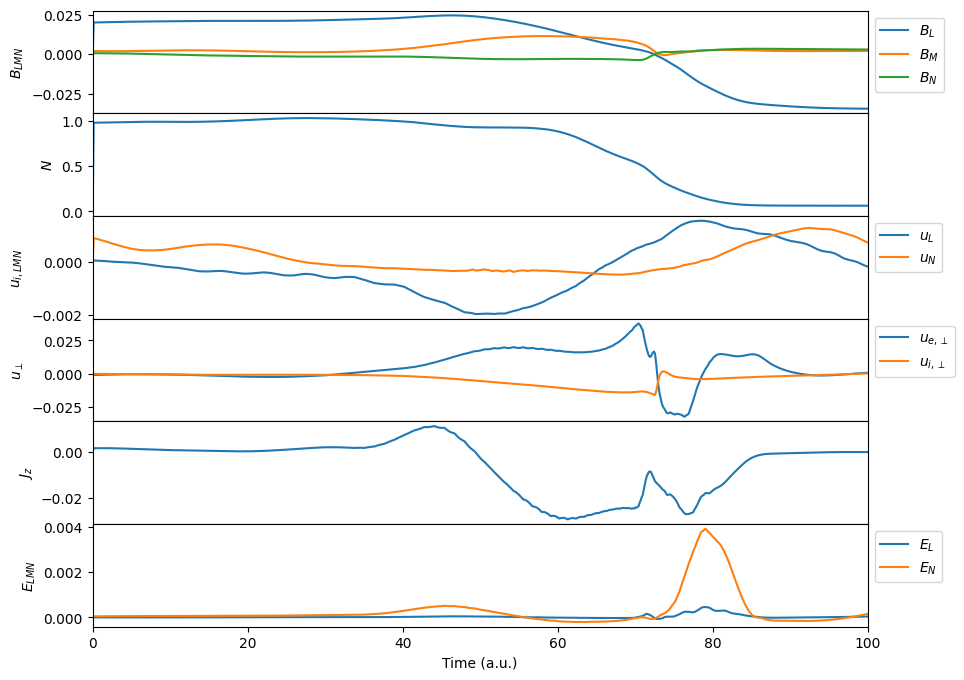

cell finished on test_cpu.


In [11]:
# Plot trajectory data
dx = r_coords[0][1] - r_coords[0][0]
dy = r_coords[1][1] - r_coords[1][0]

sc_bx = np.zeros(len(x_path))
sc_by = np.zeros(len(x_path))
sc_bz = np.zeros(len(x_path))
sc_n = np.zeros(len(x_path))
sc_ux = np.zeros(len(x_path))
sc_uy = np.zeros(len(x_path))
sc_uz = np.zeros(len(x_path))
sc_uperp_e = np.zeros(len(x_path))
sc_uperp_i = np.zeros(len(x_path))
sc_jx = np.zeros(len(x_path))
sc_jy = np.zeros(len(x_path))
sc_jz = np.zeros(len(x_path))
t = np.zeros(len(x_path))
sc_ex = np.zeros(len(x_path))
sc_ey = np.zeros(len(x_path))
sc_ez = np.zeros(len(x_path))

for j in range(Ntot - 1):
    i = j + 1
    x_coord = x_path[i]
    y_coord = y_path[i]
    
    x_vals = np.flatnonzero(np.abs(x_coord - r_coords[0]) < dx)
    y_vals = np.flatnonzero(np.abs(y_coord - r_coords[1]) < dy)
    
    t[i] = t[i-1] + np.sqrt((x_coord - x_path[i-1])**2 + (y_coord - y_path[i-1])**2)
    
    sc_bx[i] = bilinInterp(Bx[x_vals[0], y_vals[0]], Bx[x_vals[1], y_vals[0]], Bx[x_vals[0], y_vals[1]], Bx[x_vals[1], y_vals[1]], x_coord - r_coords[0][x_vals[0]], y_coord - r_coords[1][y_vals[0]], dx, dy)
    sc_by[i] = bilinInterp(By[x_vals[0], y_vals[0]], By[x_vals[1], y_vals[0]], By[x_vals[0], y_vals[1]], By[x_vals[1], y_vals[1]], x_coord - r_coords[0][x_vals[0]], y_coord - r_coords[1][y_vals[0]], dx, dy)
    sc_bz[i] = bilinInterp(Bz[x_vals[0], y_vals[0]], Bz[x_vals[1], y_vals[0]], Bz[x_vals[0], y_vals[1]], Bz[x_vals[1], y_vals[1]], x_coord - r_coords[0][x_vals[0]], y_coord - r_coords[1][y_vals[0]], dx, dy)
    sc_n[i] = bilinInterp(ntot[x_vals[0], y_vals[0]], ntot[x_vals[1], y_vals[0]], ntot[x_vals[0], y_vals[1]], ntot[x_vals[1], y_vals[1]], x_coord - r_coords[0][x_vals[0]], y_coord - r_coords[1][y_vals[0]], dx, dy)
    sc_ux[i] = bilinInterp(ux_i[x_vals[0], y_vals[0]], ux_i[x_vals[1], y_vals[0]], ux_i[x_vals[0], y_vals[1]], ux_i[x_vals[1], y_vals[1]], x_coord - r_coords[0][x_vals[0]], y_coord - r_coords[1][y_vals[0]], dx, dy)
    sc_uy[i] = bilinInterp(uy_i[x_vals[0], y_vals[0]], uy_i[x_vals[1], y_vals[0]], uy_i[x_vals[0], y_vals[1]], uy_i[x_vals[1], y_vals[1]], x_coord - r_coords[0][x_vals[0]], y_coord - r_coords[1][y_vals[0]], dx, dy)
    sc_uz[i] = bilinInterp(uz_i[x_vals[0], y_vals[0]], uz_i[x_vals[1], y_vals[0]], uz_i[x_vals[0], y_vals[1]], uz_i[x_vals[1], y_vals[1]], x_coord - r_coords[0][x_vals[0]], y_coord - r_coords[1][y_vals[0]], dx, dy)
    sc_uperp_e[i] = bilinInterp(uperp_e[x_vals[0], y_vals[0]], uperp_e[x_vals[1], y_vals[0]], uperp_e[x_vals[0], y_vals[1]], uperp_e[x_vals[1], y_vals[1]], x_coord - r_coords[0][x_vals[0]], y_coord - r_coords[1][y_vals[0]], dx, dy)
    sc_uperp_i[i] = bilinInterp(uperp_i[x_vals[0], y_vals[0]], uperp_i[x_vals[1], y_vals[0]], uperp_i[x_vals[0], y_vals[1]], uperp_i[x_vals[1], y_vals[1]], x_coord - r_coords[0][x_vals[0]], y_coord - r_coords[1][y_vals[0]], dx, dy)
    sc_jz[i] = bilinInterp(Jz[x_vals[0], y_vals[0]], Jz[x_vals[1], y_vals[0]], Jz[x_vals[0], y_vals[1]], Jz[x_vals[1], y_vals[1]], x_coord - r_coords[0][x_vals[0]], y_coord - r_coords[1][y_vals[0]], dx, dy)
    sc_ex[i] = bilinInterp(Ex[x_vals[0], y_vals[0]], Ex[x_vals[1], y_vals[0]], Ex[x_vals[0], y_vals[1]], Ex[x_vals[1], y_vals[1]], x_coord - r_coords[0][x_vals[0]], y_coord - r_coords[1][y_vals[0]], dx, dy)
    sc_ey[i] = bilinInterp(Ey[x_vals[0], y_vals[0]], Ey[x_vals[1], y_vals[0]], Ey[x_vals[0], y_vals[1]], Ey[x_vals[1], y_vals[1]], x_coord - r_coords[0][x_vals[0]], y_coord - r_coords[1][y_vals[0]], dx, dy)
    sc_ez[i] = bilinInterp(Ez[x_vals[0], y_vals[0]], Ez[x_vals[1], y_vals[0]], Ez[x_vals[0], y_vals[1]], Ez[x_vals[1], y_vals[1]], x_coord - r_coords[0][x_vals[0]], y_coord - r_coords[1][y_vals[0]], dx, dy)

t = t*100/np.max(t)
fig, ax = plt.subplots(6, sharex=True, figsize=(10,8))
ax[0].plot(t, sc_bx, label="$B_L$")
ax[0].plot(t, sc_bz, label="$B_M$")
ax[0].plot(t, sc_by, label="$B_N$")
ax[0].set_ylabel("$B_{LMN}$")
ax[0].legend(bbox_to_anchor=(1.0, 1), loc="upper left")
ax[1].plot(t, sc_n)
ax[1].set_ylabel("$N$")
ax[2].plot(t, sc_ux, label="$u_L$")
ax[2].plot(t, sc_uy, label="$u_N$")
ax[2].legend(bbox_to_anchor=(1.0, 1), loc="upper left")
ax[2].set_ylabel("$u_{i,LMN}$")
ax[3].plot(t, sc_uperp_e, label=r"$u_{e,\perp}$")
ax[3].plot(t, sc_uperp_i, label=r"$u_{i,\perp}$")
ax[3].set_ylabel(r"$u_{\perp}$")
ax[3].legend(bbox_to_anchor=(1.0, 1), loc="upper left")
ax[4].plot(t, sc_jz)
ax[4].set_ylabel("$J_z$")
ax[5].plot(t, sc_ex, label="$E_L$")
ax[5].plot(t, sc_ey, label="$E_N$")
ax[5].set_ylabel("$E_{LMN}$")
ax[5].legend(bbox_to_anchor=(1.0, 1), loc="upper left")

plt.subplots_adjust(wspace=0, hspace=0)
plt.xlim([0.0, t[-1]])
plt.xlabel('Time (a.u.)')

In [12]:
# Plot generated trajectory
if show_trajectory == True:
    vmax = np.max(Jz)
    vmin = -vmax
    plt.figure(figsize=(15,3))
    plt.pcolormesh(r_coords[0]/di, r_coords[1]/di, Jz[:,:].transpose(), vmax=vmax, vmin=vmin, cmap="seismic", shading="gouraud")
    plt.colorbar(format='%.2f', ticks=np.linspace(vmin, vmax, 3), fraction=0.046, pad=0.04)
    plt.contour(r_coords[0]/di, r_coords[1]/di, psi, 10, colors="k", linestyles="solid")
    plt.plot(x_path, y_path, linewidth=1, color='green', ls='--')
    plt.xlabel(r'$x/d_i$')
    plt.ylabel(r'$y/d_i$')
    plt.scatter(r_coords[0][saddles[file_idx][1]]/di, r_coords[1][saddles[file_idx][0]]/di, color='green', marker='X')
    plt.ylim(ymin[file_idx], ymax[file_idx])
    plt.xlim(r_coords[0][0], r_coords[0][-1])
    plt.setp(plt.gca(), aspect=1.0)
    plt.show()

executing cell on test_cpu...
waiting for cell to finish on test_cpu...
cell finished on test_cpu.


In [13]:
# Save data to file
if save_file == True:
    rd_file = "sc_data/random_%d.npz"
    np.savez(rd_file % group_id, t=t, bx=sc_bx, by=sc_by, bz=sc_bz, n=sc_n, ux=sc_ux, uy=sc_uy, uz=sc_uz, uperp_e=sc_uperp_e, uperp_i=sc_uperp_i, jz=sc_jz, ex=sc_ex, ey=sc_ey, ez=sc_ez, x=x_path, y=y_path)

executing cell on test_cpu...
waiting for cell to finish on test_cpu...
cell finished on test_cpu.


In [14]:
# Plot from datafile
if save_file == True:
    sc_data = np.load(rd_file)
    
    fig, ax = plt.subplots(6, sharex=True, figsize=(10,8))
    ax[0].plot(sc_data['t'], sc_data['bx'], label="$B_L$")
    ax[0].plot(sc_data['t'], sc_data['by'], label="$B_M$")
    ax[0].plot(sc_data['t'], sc_data['bz'], label="$B_N$")
    ax[0].set_ylabel("$B_{LMN}$")
    ax[0].legend(bbox_to_anchor=(1.0, 1), loc="upper left")
    ax[1].plot(sc_data['t'], sc_data['n'])
    ax[1].set_ylabel("$N$")
    ax[2].plot(sc_data['t'], sc_data['ux'], label="$u_L$")
    ax[2].plot(sc_data['t'], sc_data['uy'], label="$u_N$")
    ax[2].legend(bbox_to_anchor=(1.0, 1), loc="upper left")
    ax[2].set_ylabel("$u_{i,LMN}$")
    ax[3].plot(sc_data['t'], sc_data['uperp_e'], label=r"$u_{e,\perp}$")
    ax[3].plot(sc_data['t'], sc_data['uperp_i'], label=r"$u_{i,\perp}$")
    ax[3].set_ylabel(r"$u_{\perp}$")
    ax[3].legend(bbox_to_anchor=(1.0, 1), loc="upper left")
    ax[4].plot(sc_data['t'], sc_data['jz'])
    ax[4].set_ylabel("$J_z$")
    ax[5].plot(sc_data['t'], sc_data['ex'], label="$E_L$")
    ax[5].plot(sc_data['t'], sc_data['ez'], label="$E_M$")
    ax[5].plot(sc_data['t'], sc_data['ey'], label="$E_N$")
    ax[5].set_ylabel("$E_{LMN}$")
    ax[5].legend(bbox_to_anchor=(1.0, 1), loc="upper left")
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.xlim([0.0, t[-1]])
    plt.xlabel('Time (a.u.)')
    
    vmax = np.max(Jz)
    vmin = -vmax
    plt.figure(figsize=(15,3))
    plt.pcolormesh(r_coords[0]/di, r_coords[1]/di, Jz[:,:].transpose(), vmax=vmax, vmin=vmin, cmap="seismic", shading="gouraud")
    plt.colorbar(format='%.2f', ticks=np.linspace(vmin, vmax, 3), fraction=0.046, pad=0.04)
    plt.contour(r_coords[0]/di, r_coords[1]/di, psi, 10, colors="k", linestyles="solid")
    plt.plot(sc_data['x'], sc_data['y'], linewidth=1, color='green', ls='--')
    plt.xlabel(r'$x/d_i$')
    plt.ylabel(r'$y/d_i$')
    plt.scatter(r_coords[0][saddles[file_idx][1]]/di, r_coords[1][saddles[file_idx][0]]/di, color='green', marker='X')
    plt.ylim(ymin[file_idx], ymax[file_idx])
    plt.xlim(r_coords[0][0], r_coords[0][-1])
    plt.setp(plt.gca(), aspect=1.0)
    plt.show()

executing cell on test_cpu...
waiting for cell to finish on test_cpu...
cell finished on test_cpu.


In [15]:
%stop_runtime test_cpu
%switch_runtime local

Terminated runtime=test_cpu. state={'experimentId': 'CS_Agent_2f12c867-04f8-4156-bfb7-ff1252f3995c', 'terminated': True}
Switched to runtime=local.
